In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import FAIRStream

### Case 1: Forecast numeric output by 1 time step
> Predict next hour's periodic breathing burden index on preterm NICU patients, using vital signs hourly statistics </br>

Input

> 24 hours of hourly mean, std, skewness, kurtosis of Heart Rate, SPO2 percentage</br>

Output 
> next 1 hour's Periodic Breathing Burden Index</br>


#### Baseline

In [ ]:
# set up
# 1. create a fairstream instance
prvt_stream = FAIRStream.FAIRStream('../project1_hourly')# windows
# 2. define the episode
prvt_stream.engineer.DefineEpisode(input_time_len=24, output_time_len=1, time_resolution=1, time_lag=0, anchor_gap=3)
# 3. specify csv pool folder dir
csv_pool_path = '../project1_hourly/csv_pool'

# regression evaluation
eval_df_trace_folds = pd.DataFrame()
myMetrics = [
    tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.MeanAbsolutePercentageError(),
    tf.keras.metrics.MeanSquaredLogarithmicError(),
    tf.keras.metrics.CosineSimilarity(axis=1)
]

# 10 fold bootstrap
for i in range(10):
    
    train_df, valid_df, train_tfds, valid_tfds = prvt_stream.engineer.BuildMVTS(csv_pool_path, nsbj=100, train_frac=0.8, batch_size=32, impute_input='median', impute_output='median', return_data=True)
    
    eval_df_trace = pd.DataFrame()
    keras.backend.clear_session()

    # build the model
    input_shape = list(train_tfds.element_spec[0].shape)[1:3]
    lstm = keras.models.Sequential([
        keras.layers.Masking(mask_value=-333, input_shape=input_shape),
        keras.layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1*3),
        tf.keras.layers.Reshape([3, 1])
    ])
    lstm.summary()

    # compile and run the model
    lstm.compile(loss=tf.losses.MeanSquaredError(), optimizer=keras.optimizers.Adam(lr=1e-4), metrics=myMetrics)
    callback = EarlyStopping(monitor='val_mean_squared_error', patience=10)
    his =lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-4)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-5)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-6)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)
    keras.backend.set_value(lstm.optimizer.learning_rate, 1e-7)
    his = lstm.fit(train_tfds, epochs=100, validation_data=valid_tfds, callbacks=[callback])
    eval_df_trace = pd.concat([eval_df_trace, pd.DataFrame(his.history)],sort=False)


    eval_df_trace['epoch'] = eval_df_trace.reset_index(drop=True).index
    eval_df_trace['fold'] = i + 1

    eval_df_trace_folds = pd.concat([eval_df_trace_folds, eval_df_trace],sort=False)

In [7]:
eval_df_trace_folds.to_csv('../project1_hourly/report/eval_mtrx_case1.csv', index=False)
data= pd.read_csv('../project1_hourly/report/eval_mtrx_case1.csv')

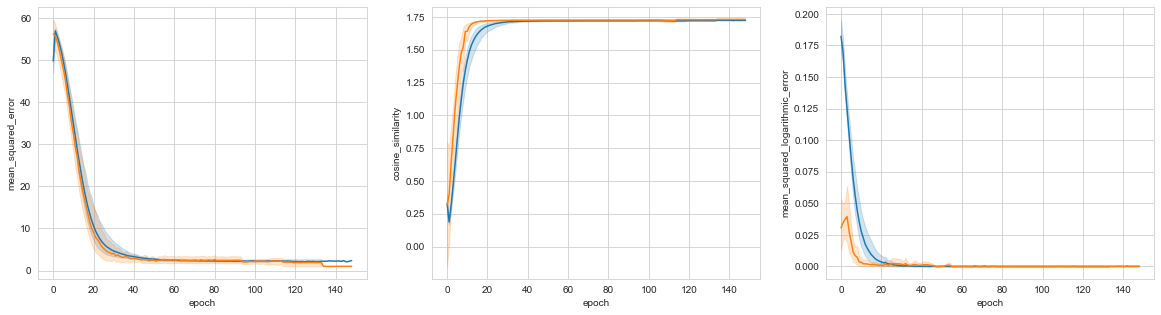

In [9]:
mtrx = 'mean_squared_error'
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs = axs.flatten()
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[0])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[0])
axs[0].set_ylabel(mtrx)
mtrx = 'cosine_similarity'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[1])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[1])
axs[1].set_ylabel(mtrx)
mtrx='mean_squared_logarithmic_error'
sns.lineplot(x='epoch',y=mtrx, data=data, ax=axs[2])
sns.lineplot(x='epoch',y='val_'+mtrx, data=data, ax=axs[2])
axs[2].set_ylabel(mtrx)
plt.show();